# Plots for low-energy-reco paper

In [1]:
import h5py
import numpy as np
from scipy import stats
import dama as dm
from dama.utils.stats import weighted_quantile
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd

In [2]:
from matplotlib.ticker import ScalarFormatter

#'figure.figsize': (12, 12*0.618),
params = {'legend.fontsize': 16,
          'axes.labelsize': 16,
          'axes.titlesize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16, 
          'axes.formatter.useoffset': False,
         }
plt.rcParams.update(params)

In [88]:
def load_file(f_name, keys, itype=['numu_cc']): #, n_evts=None
    try: 
        f = h5py.File(f_name, 'r')
        if itype[0] == 'all':
            itype = list(f.keys())
            
        var_dict = {}
        for k in keys:
            arr = np.array([])
            for i in itype:
                if i == 'muon': arr = np.append(arr, f[i][k][()])
                else:
                    arr = np.append(arr, f[i][k])
            var_dict[k] = arr
    except: 
        f = pd.read_csv(f_name)
        mask = np.logical_and(f["interaction_type"]==1,abs(f["pid"]) == 14)
        f = f[mask]
    
        var_dict = {}
        for k in keys:
            arr = np.array([])
            var_dict[k] = arr
    
    return dm.PointData(**var_dict)

def iqr(X, w):
    qs = weighted_quantile(X, q=[0.25, 0.75], weights=w)
    return qs[1] - qs[0]

def correct_weights(weights, flavor):
    cor = np.ones(len(weights))
    cor[np.where(flavor==12)] = 650
    cor[np.where(flavor==14)] = 1550
    cor[np.where(flavor==16)] = 350
    
    return weights/cor

In [58]:
f = h5py.File("hdf5/oscNext_pisa_genie_0000_flercnn.hdf5", 'r')
#print(f.keys())
#f['numu_cc'].keys()

In [5]:
%%time
f_name = "hdf5/oscNext_pisa_genie_0000_flercnn.hdf5"
keys = ['I3MCWeightDict.OneWeight', 'I3MCWeightDict.InteractionType', 'MCInIcePrimary.pdg_encoding',
        'I3EventHeader.event_id', 'I3EventHeader.run_id',  'I3EventHeader.sub_run_id', 
        'MCInIcePrimary.dir.coszen', 'MCInIcePrimary.energy', 'MCInIcePrimary.pos.z', 'MCExtraTruthInfo.vertex_rho36',
        'MCInIcePrimary.pos.x', 'MCInIcePrimary.pos.y', 'MCExtraTruthInfo.vertex_rho36',
    
        "FLERCNN_vertex_x", "FLERCNN_vertex_y", "FLERCNN_vertex_z", "FLERCNN_BDT_ProbNu",
        "FLERCNN_vertex_rho36", "FLERCNN_coszen", 
        "FLERCNN_energy", 'FLERCNN_nDOM', 'FLERCNN_prob_muon_v3', 'FLERCNN_prob_nu', 'FLERCNN_prob_track',
        'L4_MuonClassifier_Data_ProbNu',
        'L7_CoincidentMuon_Variables.z_travel_top15', 'L7_CoincidentMuon_bool', 'L7_NarrowCorridorCutPulsesHitStatistics.z_min',
        'L7_CoincidentMuon_Variables.n_outer', 'L7_CoincidentMuon_Variables.n_top15', 'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms',
        'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'
       ]

MC = load_file(f_name, keys, ['numu_cc'])
MC['I3MCWeightDict.OneWeight'] = correct_weights(MC['I3MCWeightDict.OneWeight'], np.abs(MC['MCInIcePrimary.pdg_encoding']))
print(f'Loaded {MC.size} events')


Loaded 2845992 events
CPU times: user 286 ms, sys: 919 ms, total: 1.21 s
Wall time: 8.09 s


In [6]:
cuts = (MC.FLERCNN_vertex_z > -495.) & (MC.FLERCNN_vertex_z < -225.) & (MC.FLERCNN_vertex_rho36 < 200.) \
    & ( MC['L7_CoincidentMuon_Variables.n_top15'] < 0.5 ) & ( MC['L7_CoincidentMuon_Variables.n_outer'] < 7.5 ) \
    & (MC['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms'] > 2.5) & (MC.FLERCNN_nDOM >=7) \
    & (MC['FLERCNN_energy'] >= 5.) & (MC['FLERCNN_energy'] <= 100.) & (MC['FLERCNN_coszen'] <= 0.0)
np.sum(cuts)

1056527

### allP vs trueE

In [7]:
sub_d = MC[['MCInIcePrimary.energy']]

sub_d.x_err = MC['FLERCNN_vertex_x'] - MC['MCInIcePrimary.pos.x']
sub_d.y_err = MC['FLERCNN_vertex_y'] - MC['MCInIcePrimary.pos.y']
sub_d.z_err = MC['FLERCNN_vertex_z'] - MC['MCInIcePrimary.pos.z']
sub_d.rho_err = MC['FLERCNN_vertex_rho36'] - MC['MCExtraTruthInfo.vertex_rho36']

sub_d.zen_err = MC['FLERCNN_coszen'] - MC['MCInIcePrimary.dir.coszen']
sub_d.E_err = (MC['FLERCNN_energy'] - MC['MCInIcePrimary.energy'])/MC['MCInIcePrimary.energy']

sub_d.weights = MC['I3MCWeightDict.OneWeight']


In [8]:
bins = np.logspace(np.log10(5), 2, 100)
#bw = sub_d[cuts].binwise(**{'visible_energy':bins}).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])
#bwc = sub_d[(MC.L7_reconstructed_cascade_energy!=0)&(cuts)].binwise(**{'true_cascade_energy':bins}).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])
#bwt = sub_d[cuts].binwise(**{'true_track_energy':np.insert(bins, 0, 0)}).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])
bw = sub_d[cuts].binwise(**{'MCInIcePrimary.energy':bins}).apply_function(weighted_quantile, q=[0.05, 0.16, 0.5, 0.84, 0.95], weights='weights')

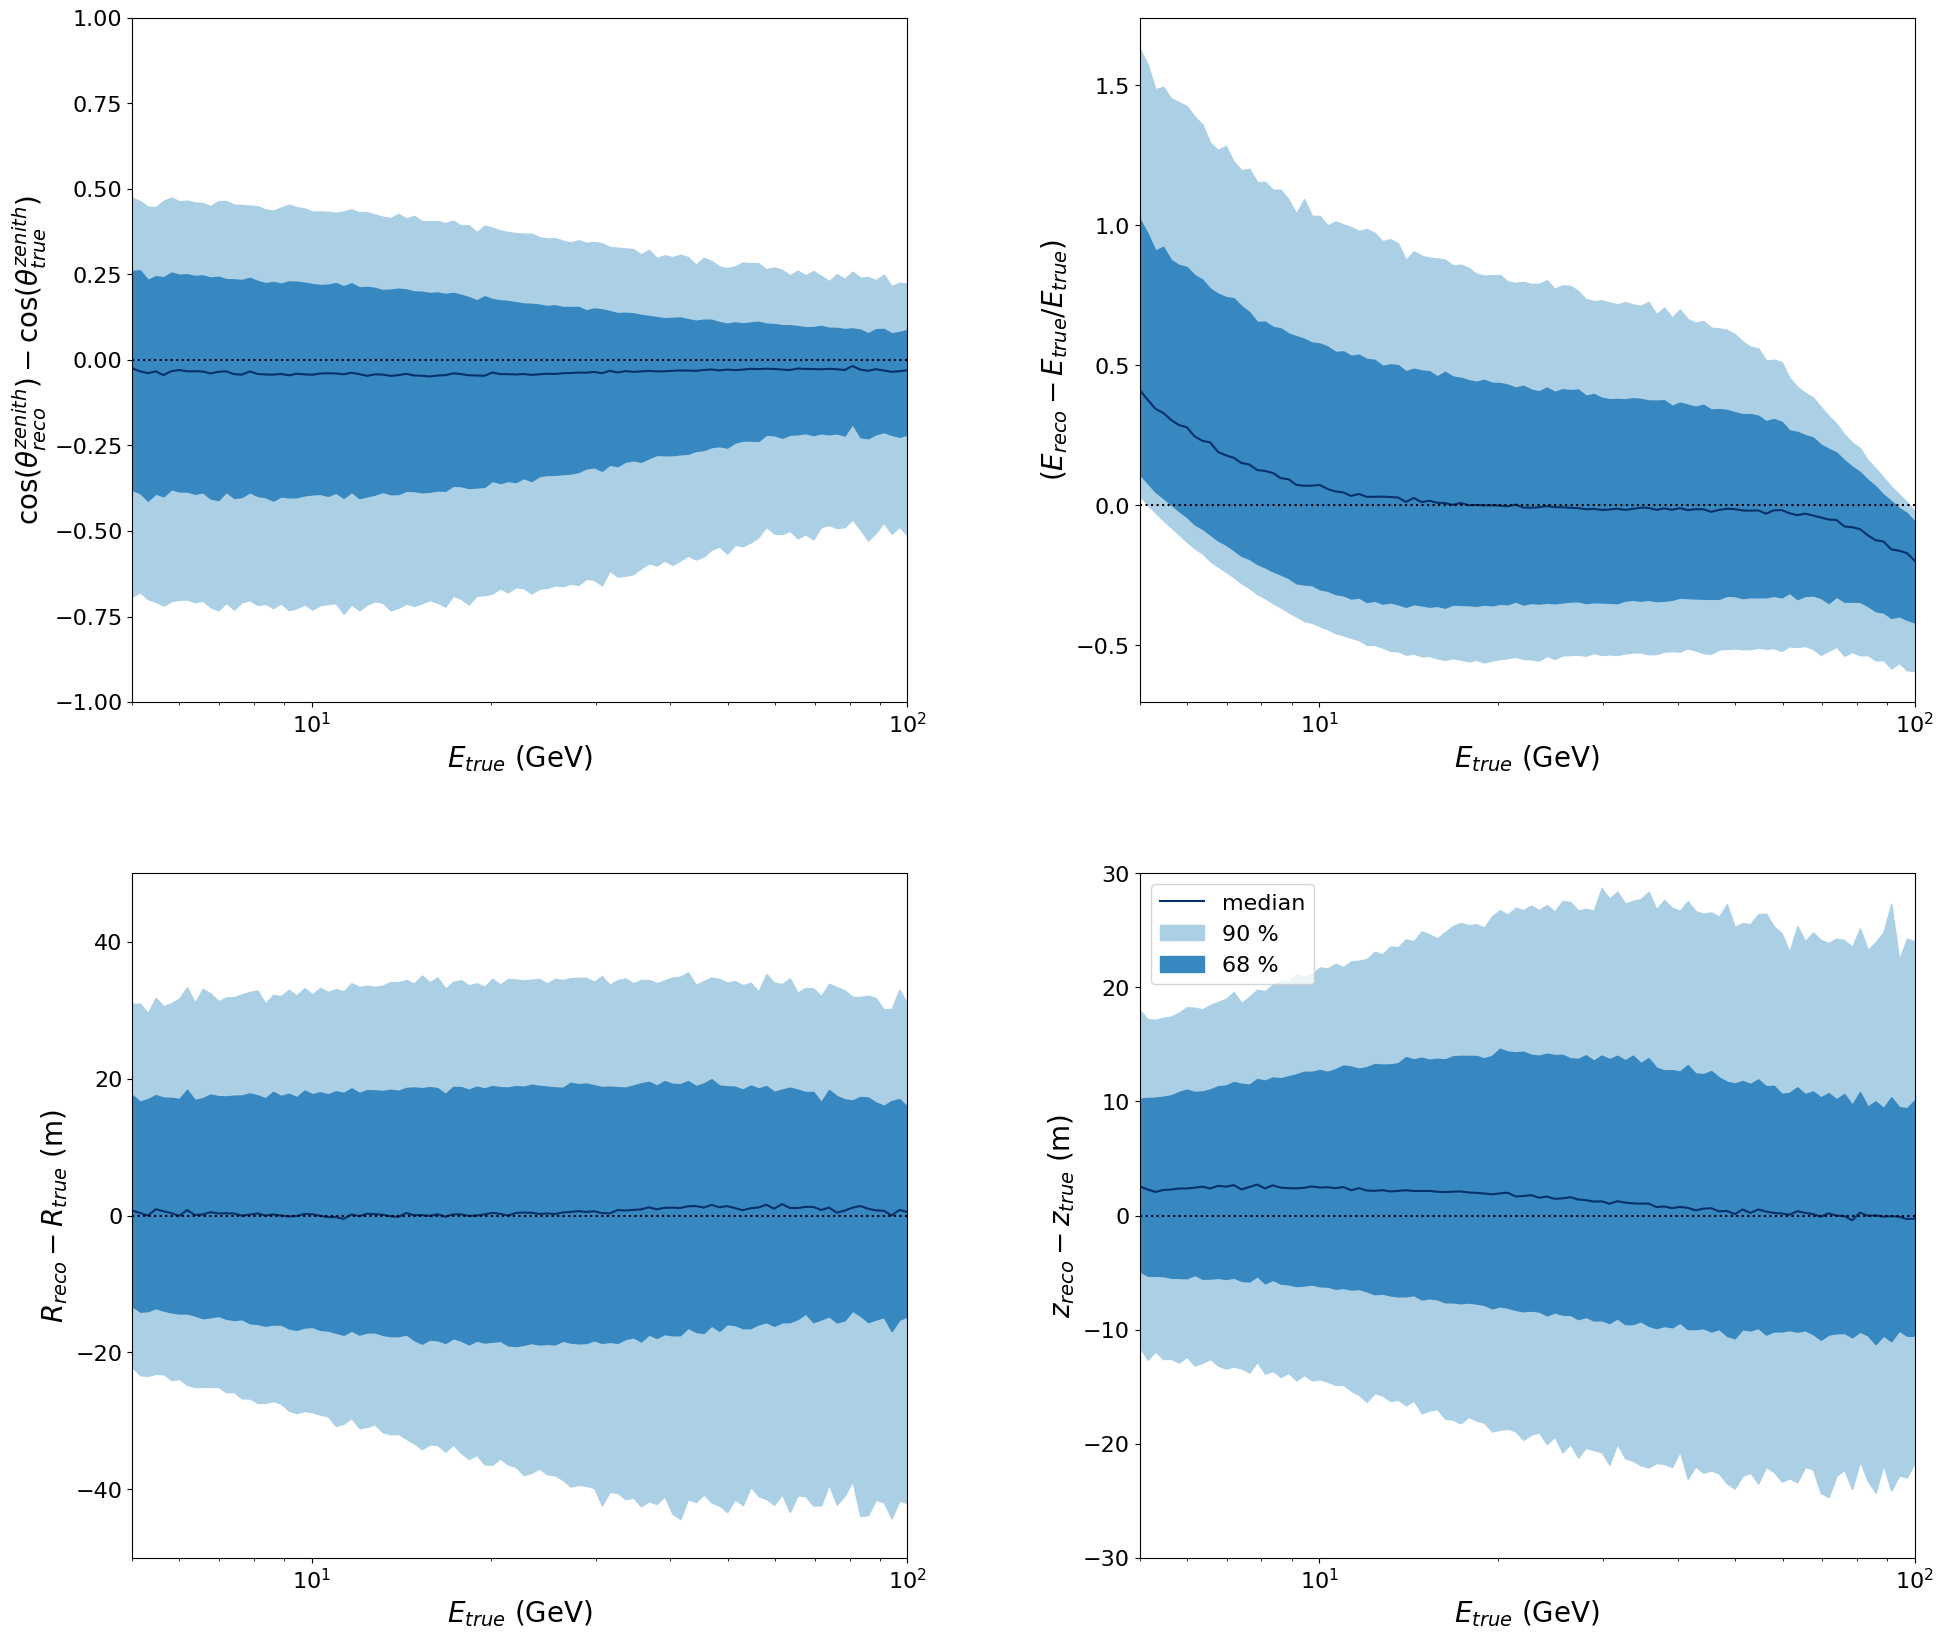

In [9]:
plt.figure(figsize=(23, 20))
plt.subplots_adjust(wspace=0.3, hspace=0.25)
s = 20

plt.subplot(221)
bw.plot_bands('zen_err', cmap='Blues', labels=['IQ90', 'IQ50', 'median'])
plt.axhline(0, color='black', linestyle=':')
plt.ylim(-1,1)
plt.xlabel(r'$E_{true}$ (GeV)', size=s)
plt.ylabel(r'$\cos(\theta^{zenith}_{reco})-\cos(\theta^{zenith}_{true})$', size=s)

plt.subplot(222)
bw.plot_bands('E_err', cmap='Blues', labels=['IQ90', 'IQ50', 'median'])
plt.axhline(0, color='black', linestyle=':')
plt.xlabel(r'$E_{true}$ (GeV)', size=s)
plt.ylabel(r'$(E_{reco} - E_{true} / E_{true})$', size=s)

'''plt.subplot(234)
bw.plot_bands('x_err', cmap='Blues', labels=['IQ90', 'IQ50', 'median'])
plt.axhline(0, color='black', linestyle=':')
plt.xlabel(r'$E_{true}$ (GeV)', size=s)
plt.ylabel(r'$x_{reco}-x_{true}$ (m)', size=s)

plt.subplot(235)
bw.plot_bands('y_err', cmap='Blues', labels=['IQ90', 'IQ50', 'median'])
plt.axhline(0, color='black', linestyle=':')
plt.xlabel(r'$E_{true}$ (GeV)', size=s)
plt.ylabel(r'$y_{reco}-y_{true}$ (m)', size=s)'''

plt.subplot(223)
bw.plot_bands('rho_err', cmap='Blues', labels=['IQ90', 'IQ50', 'median'])
plt.axhline(0, color='black', linestyle=':')
plt.xlabel(r'$E_{true}$ (GeV)', size=s)
plt.ylim(-50,50)
plt.ylabel(r'$R_{reco}-R_{true}$ (m)', size=s)


plt.subplot(224)
bw.plot_bands('z_err', cmap='Blues', labels=['90 %', '68 %', 'median'])
plt.axhline(0, color='black', linestyle=':')
plt.legend(loc='upper left')
plt.xlabel(r'$E_{true}$ (GeV)', size=s)
plt.ylabel(r'$z_{reco}-z_{true}$ (m)', size=s)
plt.ylim(-30,30)
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useOffset=False))
#plt.ylim(-25, 60)


plt.savefig('plots/numuCC_flercnn_all_res_vs_trueE_weight', bbox_inches='tight')

Reco-Truth distributions

In [10]:
'''santa_azi = MC['L6_SANTA_sel_Particle.dir.azimuth']%(2*np.pi)
bins = np.linspace(-2, 2, 250)
mask = (~np.isnan(santa_azi)) & ((MC['L6_SANTA_sel.chi2']/MC['L6_SANTA_sel.dof'])<50) & (~np.isnan(MC['SPEFit2.dir.azimuth'])) #& (cuts)
S = santa_azi[mask]-MC['MCInIcePrimary.dir.azimuth'][mask]
R = MC['L7_reconstructed_azimuth'][mask]-MC['MCInIcePrimary.dir.azimuth'][mask] 
SPE = MC['SPEFit2.dir.azimuth'][mask]-MC['MCInIcePrimary.dir.azimuth'][mask]

S = np.where(S<-np.pi, S+2*np.pi, S)
S = np.where(S>np.pi, S-2*np.pi, S)
R = np.where(R<-np.pi, R+2*np.pi, R)
R = np.where(R>np.pi, R-2*np.pi, R)
SPE = np.where(SPE<-np.pi, SPE+2*np.pi, SPE)
SPE = np.where(SPE>np.pi, SPE-2*np.pi, SPE)

n_str = MC['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'][mask]'''

"santa_azi = MC['L6_SANTA_sel_Particle.dir.azimuth']%(2*np.pi)\nbins = np.linspace(-2, 2, 250)\nmask = (~np.isnan(santa_azi)) & ((MC['L6_SANTA_sel.chi2']/MC['L6_SANTA_sel.dof'])<50) & (~np.isnan(MC['SPEFit2.dir.azimuth'])) #& (cuts)\nS = santa_azi[mask]-MC['MCInIcePrimary.dir.azimuth'][mask]\nR = MC['L7_reconstructed_azimuth'][mask]-MC['MCInIcePrimary.dir.azimuth'][mask] \nSPE = MC['SPEFit2.dir.azimuth'][mask]-MC['MCInIcePrimary.dir.azimuth'][mask]\n\nS = np.where(S<-np.pi, S+2*np.pi, S)\nS = np.where(S>np.pi, S-2*np.pi, S)\nR = np.where(R<-np.pi, R+2*np.pi, R)\nR = np.where(R>np.pi, R-2*np.pi, R)\nSPE = np.where(SPE<-np.pi, SPE+2*np.pi, SPE)\nSPE = np.where(SPE>np.pi, SPE-2*np.pi, SPE)\n\nn_str = MC['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'][mask]"

In [11]:
'''
sub_d = dm.PointData()
sub_d.S = S
sub_d.R = R
sub_d.SPE = SPE
sub_d.weights = MC['I3MCWeightDict.weight'][mask]

plt.figure(figsize=(8,8*0.618))

#sub_d[n_str==1].kde(S=1000).density.plot(color='b', linestyle='--', label='SANTA single string (IQ50=%.2f)'%(stats.iqr(S[n_str==1])))
sub_d[n_str>1].kde(S=1000).weights.plot(color='tab:Orange', label='SANTA MS (IQR=%.2f)'%(iqr(S[n_str>1], sub_d.weights[n_str>1])))
sub_d[n_str==1].kde(R=1000).weights.plot(color='tab:Blue', linestyle='--', label='RETRO SS (IQR=%.2f)'%(iqr(R[n_str==1], sub_d.weights[n_str==1])))
sub_d[n_str>1].kde(R=1000).weights.plot(color='tab:Blue', label='RETRO MS (IQR=%.2f)'%(iqr(R[n_str>1], sub_d.weights[n_str>1])))
sub_d[n_str==1].kde(SPE=1000).weights.plot(color='black', linestyle='--', label='SPE SS (IQR=%.2f)'%(iqr(SPE[n_str==1], sub_d.weights[n_str==1])))
sub_d[n_str>1].kde(SPE=1000).weights.plot(color='black', label='SPE MS (IQR=%.2f)'%(iqr(SPE[n_str>1], sub_d.weights[n_str>1])))
plt.axvline(0, color='grey', linestyle='--')

plt.legend(prop={'size': 14})
plt.xlabel(r'$\phi^{azimuth}_{reco}-\phi^{azimuth}_{true}$')
plt.ylabel('Density')
plt.ylim(0, 2.7)

#plt.savefig('plots/azi_res_nstr_weight', bbox_inches='tight')
'''

"\nsub_d = dm.PointData()\nsub_d.S = S\nsub_d.R = R\nsub_d.SPE = SPE\nsub_d.weights = MC['I3MCWeightDict.weight'][mask]\n\nplt.figure(figsize=(8,8*0.618))\n\n#sub_d[n_str==1].kde(S=1000).density.plot(color='b', linestyle='--', label='SANTA single string (IQ50=%.2f)'%(stats.iqr(S[n_str==1])))\nsub_d[n_str>1].kde(S=1000).weights.plot(color='tab:Orange', label='SANTA MS (IQR=%.2f)'%(iqr(S[n_str>1], sub_d.weights[n_str>1])))\nsub_d[n_str==1].kde(R=1000).weights.plot(color='tab:Blue', linestyle='--', label='RETRO SS (IQR=%.2f)'%(iqr(R[n_str==1], sub_d.weights[n_str==1])))\nsub_d[n_str>1].kde(R=1000).weights.plot(color='tab:Blue', label='RETRO MS (IQR=%.2f)'%(iqr(R[n_str>1], sub_d.weights[n_str>1])))\nsub_d[n_str==1].kde(SPE=1000).weights.plot(color='black', linestyle='--', label='SPE SS (IQR=%.2f)'%(iqr(SPE[n_str==1], sub_d.weights[n_str==1])))\nsub_d[n_str>1].kde(SPE=1000).weights.plot(color='black', label='SPE MS (IQR=%.2f)'%(iqr(SPE[n_str>1], sub_d.weights[n_str>1])))\nplt.axvline(0, col

### Cos(zen) plots

Reco-Truth distributions for common events

In [12]:
def find_common_number3(arr1, arr2,arr3):
    a1 = np.array(arr1)
    a2 = np.array(arr2)
    a3 = np.array(arr3)
    
    set1 = set(a1)
    set2 = set(a2)
    set3 = set(a3)
    
    common_numbers = set1.intersection(set2).intersection(set3)
    #common_numbers = set1.intersection(set2)
    
    return list(common_numbers)

In [13]:
def find_common_number2(arr1, arr2):
    a1 = np.array(arr1)
    a2 = np.array(arr2)
    
    set1 = set(a1)
    set2 = set(a2)
    
    common_numbers = set1.intersection(set2)
    
    return list(common_numbers)

In [14]:
def create_mask(array, values):
    indices = np.where(np.isin(array, values))[0]
    mask = np.zeros_like(array, dtype=bool)
    mask[indices] = True
    return mask

In [15]:
f_retro = h5py.File("hdf5/oscNext_pisa_genie_0000_v02.02.hdf5","r")
f_val = h5py.File("hdf5/oscnext_santaleera_genie_0000.hdf5","r")
f_flercnn = h5py.File("hdf5/oscNext_pisa_genie_0000_flercnn.hdf5","r")
f_gnn = pd.read_csv("hdf5/reconstruction.csv") #, names=["energy", "zenith", "zenith_pred","energy_pred",

In [16]:
f_gnn.keys()

Index(['Unnamed: 0', 'zenith_pred', 'zenith_kappa', 'event_no', 'energy_pred',
       'azimuth_pred', 'azimuth_kappa', 'position_x_pred', 'position_y_pred',
       'position_z_pred', 'L4_MuonClassifier_Data_ProbNu',
       'L4_NoiseClassifier_ProbNu', 'L7_MuonClassifier_FullSky_ProbNu',
       'L7_PIDClassifier_FullSky_ProbTrack', 'azimuth_retro', 'azimuth_sigma',
       'cascade_energy_retro', 'energy_retro', 'energy_sigma', 'osc_weight',
       'position_x_retro', 'position_x_sigma', 'position_y_retro',
       'position_y_sigma', 'position_z_retro', 'position_z_sigma',
       'time_retro', 'time_sigma', 'track_energy_retro', 'track_length_retro',
       'zenith_retro', 'zenith_sigma', 'EventID', 'RunID', 'SubEventID',
       'SubrunID', 'azimuth', 'elasticity', 'energy', 'event_time',
       'interaction_type', 'pid', 'position_x', 'position_y', 'position_z',
       'sim_type', 'zenith', 'track'],
      dtype='object')

In [17]:
gnn_keys = ['EventID', 'RunID', 'SubEventID', 
        'zenith', 'energy', 'osc_weight', 'interaction_type',
        'zenith_retro', 'energy_retro','position_x_retro', 'position_y_retro', 'position_z_retro',
        'zenith_pred', 'energy_pred', 
        'position_x_pred', 'position_y_pred', 'position_z_pred'
       ]
f_name = "hdf5/reconstruction.csv"
MC_gnn = load_file(f_name, gnn_keys, itype=['numu_cc'])
#MC_gnn['I3MCWeightDict.OneWeight'] = correct_weights(MC_santa['I3MCWeightDict.OneWeight'], np.abs(MC_santa['MCInIcePrimary.pdg_encoding']))

print(f'Loaded {MC_gnn.size} events')

Loaded 0 events


In [18]:
#recos = ["flercnn","retro","val"]
recos = ["flercnn","val"]
keys = ["energy","dir.coszen"]
data = {}
branch = "MCInIcePrimary."
common_event_mask = {}

In [19]:
santa_keys = ['I3EventHeader.event_id', 'I3EventHeader.run_id', 'I3EventHeader.sub_run_id', 
        'MCInIcePrimary.dir.coszen', 'MCInIcePrimary.energy', 'I3MCWeightDict.OneWeight', 'I3MCWeightDict.InteractionType',
        
        'SANTA_LEERAFit_DefaultSelection_Particle.energy', 'SANTA_LEERAFit_DefaultSelection_Particle.dir.coszen',
        'GBM_PID.value', 'SANTA_LEERAFit_result_dict.SuccessfulFit', 'L5_oscNext_bool.value', 'SRTTWOfflinePulsesDC_ContainmentVars.n_outer',
        'SRTTWOfflinePulsesDC_ContainmentVars.z_travel_top15','SANTA_sel_reduced_chisquare.value','L4_MuonClassifier_Data_ProbNu.value',
        'MCInIcePrimary.pdg_encoding', 'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'
       ]
f_name = "hdf5/oscnext_santaleera_genie_0000.hdf5"
MC_santa = load_file(f_name, santa_keys, itype=['numu_cc'])
MC_santa['I3MCWeightDict.OneWeight'] = correct_weights(MC_santa['I3MCWeightDict.OneWeight'], np.abs(MC_santa['MCInIcePrimary.pdg_encoding']))

print(f'Loaded {MC_santa.size} events')

Loaded 1313174 events


In [20]:
MC_flercnn = MC

In [21]:
#df_santa = MC_santa[common_event_mask['val']]
#df_flercnn = MC_flercnn[common_event_mask['flercnn']]

In [22]:
cuts_santa = (MC_santa['SANTA_sel_reduced_chisquare.value'] < 50)
#(MC_santa['L4_MuonClassifier_Data_ProbNu.value'] > 0.97) & (MC_santa['SANTA_sel_reduced_chisquare.value'] < 50) & (MC_santa['SANTA_LEERAFit_result_dict.SuccessfulFit']>=1) \
#            & (MC_santa['SRTTWOfflinePulsesDC_ContainmentVars.n_outer']<8) & (MC_santa['SRTTWOfflinePulsesDC_ContainmentVars.z_travel_top15'] >=0)

In [23]:
np.min(MC_santa[cuts_santa]['MCInIcePrimary.dir.coszen'])

-0.999997856930674

In [24]:
df_santa = MC_santa[cuts_santa]

for r in recos:
    data[r] = {}

for k in keys:
    data[recos[0]][k] = MC_flercnn[branch+k] 
    #data[particle][recos[1]][k] = f_retro[particle][branch+k]
    data[recos[1]][k] = df_santa[branch+k]
    
for r in recos:
    trans = np.vstack((data[r][keys[0]],
                            data[r][keys[1]]))
    data[r]["unique_id"] = trans[0,:]*trans[1,:]
    assert(len(set(np.array(data[r]["unique_id"])))==len(data[r]["unique_id"])) # Checks to make sure each event has a uniqueID

common_numbers2 = find_common_number2(data[recos[0]]["unique_id"],
                                      data[recos[1]]["unique_id"]) #,
                                     #data[particle][recos[2]]["unique_id"])
assert(len(common_numbers2)<len(data[recos[1]]["unique_id"])) #should not exceed valdiation sample size

for r in recos:
    common_event_mask[r] = (create_mask(data[r]["unique_id"],common_numbers2))

In [25]:
df_santa = df_santa[common_event_mask['val']]
df_flercnn = MC_flercnn[common_event_mask['flercnn']]

In [26]:
np.nanmin(df_santa['SANTA_LEERAFit_DefaultSelection_Particle.dir.coszen'])

-1.0

In [27]:
for s, f in zip(list(df_santa['I3MCWeightDict.OneWeight']), list(df_flercnn['I3MCWeightDict.OneWeight'])):
    if s==f:
        continue
    else: print(s, f)

In [28]:
assert list(df_santa['I3MCWeightDict.OneWeight']) == list(df_flercnn['I3MCWeightDict.OneWeight'])

In [29]:
len(df_santa['I3EventHeader.event_id'])

1090114

In [30]:
santa_cos = df_santa['SANTA_LEERAFit_DefaultSelection_Particle.dir.coszen']

mask = (~np.isnan(santa_cos)) #& (~np.isnan(MC['SPEFit2.dir.zenith'])) #& (cuts)
santa_zen_error = santa_cos[mask]-df_santa['MCInIcePrimary.dir.coszen'][mask]
flercnn_zen_error = df_flercnn['FLERCNN_coszen'][mask]-df_flercnn['MCInIcePrimary.dir.coszen'][mask]
n_str = df_santa['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'][mask]

/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")


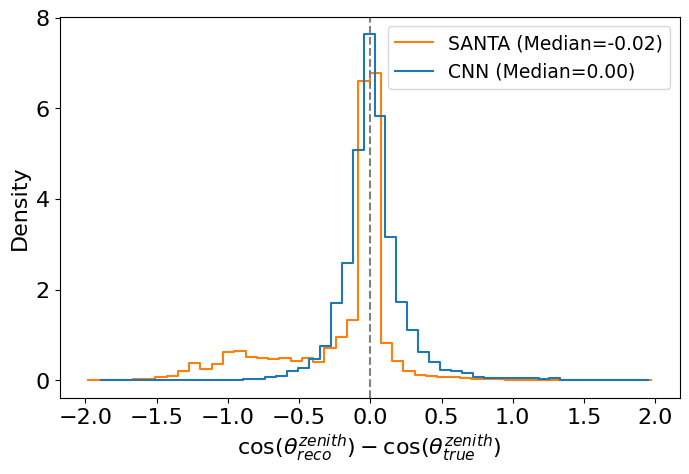

In [31]:
sub_d = dm.PointData()
sub_d.S = santa_zen_error
sub_d.F = flercnn_zen_error
sub_d.weights = df_santa['I3MCWeightDict.OneWeight'][mask]

plt.figure(figsize=(8,8*0.618))
kde = 50
#sub_d[n_str==1].kde(S=kde).weights.plot(color='tab:Orange', linestyle='--', label='SANTA SS (IQR=%.2f)'%(iqr(santa_zen_error[n_str==1], sub_d.weights[n_str==1])))
#sub_d[n_str>1].kde(S=kde).weights.plot(color='tab:Orange', label='SANTA MS (IQR=%.2f)'%(iqr(santa_zen_error[n_str>1], sub_d.weights[n_str>1])))
#sub_d[n_str==1].kde(F=kde).weights.plot(color='tab:Blue', linestyle='--', label='FLECNN SS (IQR=%.2f)'%(iqr(flercnn_zen_error[n_str==1], sub_d.weights[n_str==1])))
#sub_d[n_str>1].kde(F=kde).weights.plot(color='tab:Blue', label='RETRO MS (IQR=%.2f)'%(iqr(flercnn_zen_error[n_str>1], sub_d.weights[n_str>1])))
sub_d[n_str>=1].kde(S=kde).weights.plot(color='tab:Orange', label='SANTA (Median=%.2f)'%(weighted_quantile(santa_zen_error, q=[0.5], weights=sub_d.weights)))

sub_d[n_str>=1].kde(F=kde).weights.plot(color='tab:Blue', label='CNN (Median=%.2f)'%(weighted_quantile(flercnn_zen_error, q=[0.5], weights=sub_d.weights)))

plt.axvline(0, color='grey', linestyle='--')

plt.legend(prop={'size': 13.5})
plt.xlabel(r'$\cos(\theta^{zenith}_{reco})-\cos(\theta^{zenith}_{true})$')
#plt.xlabel(r'$\theta^{zenith}_{reco}-\theta^{zenith}_{true}$')
plt.ylabel('Density')
#plt.ylim(0, 5) #3

plt.savefig('plots/coszen_res_nstr_weight', bbox_inches='tight') #

/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/KDEpy/bw_selection.py:262: UserWarning: Silverman's rule currently ignores all weights
  warnings.warn("Silverman's rule currently ignores all weights")


(-5.0, 5.0)

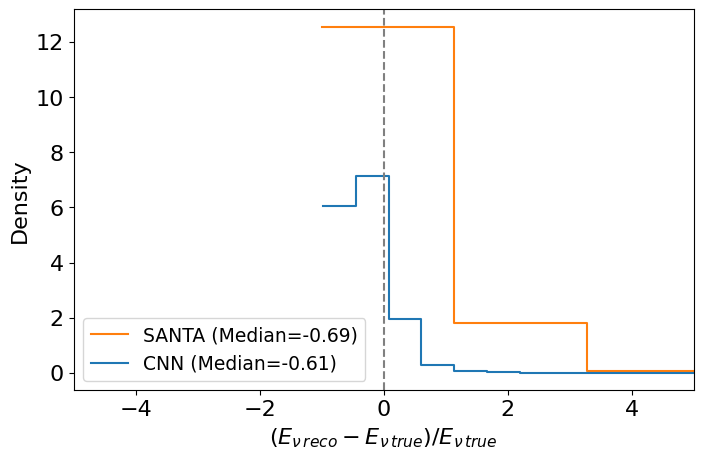

In [32]:
santa_energy = df_santa['SANTA_LEERAFit_DefaultSelection_Particle.energy']

mask = (~np.isnan(santa_cos)) #& (~np.isnan(MC['SPEFit2.dir.zenith'])) #& (cuts)
santa_e_error = (santa_energy[mask]-df_santa['MCInIcePrimary.energy'][mask])/df_santa['MCInIcePrimary.energy'][mask]
flercnn_e_error = (df_flercnn['FLERCNN_energy'][mask]-df_flercnn['MCInIcePrimary.energy'][mask])/df_flercnn['MCInIcePrimary.energy'][mask]
n_str = df_santa['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'][mask]

sub_d = dm.PointData()
sub_d.S = santa_e_error
sub_d.F = flercnn_e_error
sub_d.weights = df_santa['I3MCWeightDict.OneWeight'][mask]

plt.figure(figsize=(8,8*0.618))
kde = 100
#sub_d[n_str==1].kde(S=kde).weights.plot(color='tab:Orange', linestyle='--', label='SANTA SS (IQR=%.2f)'%(iqr(santa_zen_error[n_str==1], sub_d.weights[n_str==1])))
#sub_d[n_str>1].kde(S=kde).weights.plot(color='tab:Orange', label='SANTA MS (IQR=%.2f)'%(iqr(santa_zen_error[n_str>1], sub_d.weights[n_str>1])))
#sub_d[n_str==1].kde(F=kde).weights.plot(color='tab:Blue', linestyle='--', label='FLECNN SS (IQR=%.2f)'%(iqr(flercnn_zen_error[n_str==1], sub_d.weights[n_str==1])))
#sub_d[n_str>1].kde(F=kde).weights.plot(color='tab:Blue', label='RETRO MS (IQR=%.2f)'%(iqr(flercnn_zen_error[n_str>1], sub_d.weights[n_str>1])))
sub_d[n_str>=1].kde(S=kde).weights.plot(color='tab:Orange', label='SANTA (Median=%.2f)'%(weighted_quantile(santa_e_error, q=[0.5], weights=sub_d.weights)))

sub_d[n_str>=1].kde(F=kde).weights.plot(color='tab:Blue', label='CNN (Median=%.2f)'%(weighted_quantile(flercnn_e_error, q=[0.5], weights=sub_d.weights)))

plt.axvline(0, color='grey', linestyle='--')

plt.legend(prop={'size': 13.5})

plt.xlabel(r'$(E_{\nu\,reco}-E_{\nu\,true})/E_{\nu\,true}$')
plt.ylabel('Density')
plt.xlim(-5, 5) #3

#plt.savefig('plots/coszen_res_nstr_weight', bbox_inches='tight') #

In [33]:
sub_d = dm.PointData()
sub_d.S = santa_cos[mask]
sub_d.F = flercnn_cos[mask]
sub_d.weights = df_santa['I3MCWeightDict.OneWeight'][mask]

plt.figure(figsize=(8,8*0.618))
kde = 50
#sub_d[n_str==1].kde(S=kde).weights.plot(color='tab:Orange', linestyle='--', label='SANTA SS (IQR=%.2f)'%(iqr(santa_zen_error[n_str==1], sub_d.weights[n_str==1])))
#sub_d[n_str>1].kde(S=kde).weights.plot(color='tab:Orange', label='SANTA MS (IQR=%.2f)'%(iqr(santa_zen_error[n_str>1], sub_d.weights[n_str>1])))
#sub_d[n_str==1].kde(F=kde).weights.plot(color='tab:Blue', linestyle='--', label='FLECNN SS (IQR=%.2f)'%(iqr(flercnn_zen_error[n_str==1], sub_d.weights[n_str==1])))
#sub_d[n_str>1].kde(F=kde).weights.plot(color='tab:Blue', label='RETRO MS (IQR=%.2f)'%(iqr(flercnn_zen_error[n_str>1], sub_d.weights[n_str>1])))
sub_d[n_str>=1].kde(S=kde).weights.plot(color='tab:Orange', label='SANTA (Median=%.2f)'%(weighted_quantile(santa_zen_error, q=[0.5], weights=sub_d.weights)))

sub_d[n_str>=1].kde(F=kde).weights.plot(color='tab:Blue', label='CNN (Median=%.2f)'%(weighted_quantile(flercnn_zen_error, q=[0.5], weights=sub_d.weights)))

plt.axvline(0, color='grey', linestyle='--')

plt.legend(prop={'size': 13.5})
plt.xlabel(r'$\cos(\theta^{zenith}_{reco})$')
#plt.xlabel(r'$\theta^{zenith}_{reco}-\theta^{zenith}_{true}$')
plt.ylabel('Density')
#plt.ylim(0, 5) #3

#plt.savefig('plots/coszen_res_nstr_weight', bbox_inches='tight') #

NameError: name 'flercnn_cos' is not defined

Reco vs True

/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/dama/utils/stats.py:170: RuntimeWarning: divide by zero encountered in divide
  (2 * x0 * w1) / ((x0 - x1)**2 * (w1 + w0)) -
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/dama/utils/stats.py:171: RuntimeWarning: divide by zero encountered in divide
  (2 * w0 * x1) / ((x0 - x1)**2 * (w1 + w0))
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/dama/utils/stats.py:170: RuntimeWarning: invalid value encountered in subtract
  (2 * x0 * w1) / ((x0 - x1)**2 * (w1 + w0)) -
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/dama/utils/stats.py:173: RuntimeWarning: divide by zero encountered in divide
  w0 / ((x0 - x1)**2 * (w1 + w0)) - w1 /
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8/site-packages/dama/utils/stats.py:173: RuntimeWarning: invalid value encountered in subtract
  w0 / ((x0 - x1)**2 * (w1 + w0)) - w1 /
/mnt/home/yushiqi2/anaconda3/envs/py38/lib/python3.8

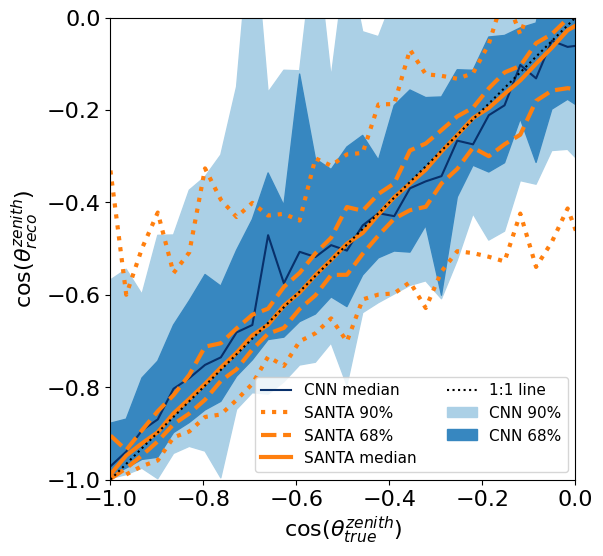

In [34]:
sub_d = df_flercnn[['FLERCNN_coszen', 'MCInIcePrimary.dir.coszen']][mask]

sub_d.santa_cos = santa_cos[mask]
sub_d.F = df_flercnn['FLERCNN_coszen'][mask]
sub_d.weights = df_flercnn['I3MCWeightDict.OneWeight'][mask]
#sub_d.santa_cos = np.arccos(sub_d.santa_cos)
#sub_d.L7_reconstructed_coszen = np.arccos(sub_d.L7_reconstructed_coszen)
#sub_d['MCInIcePrimary.dir.coszen'] = np.arccos(sub_d['MCInIcePrimary.dir.coszen'])
bins = np.linspace(-1, 1, 60) #p.linspace(0, np.pi, 100) #

plt.figure(figsize=(6,6))

#bw = sub_d.binwise(**{'MCInIcePrimary.dir.coszen':bins}).quantile(q=[0.05, 0.25, 0.5, 0.75, 0.95])
bw = sub_d.binwise(**{'MCInIcePrimary.dir.coszen':bins}).apply_function(weighted_quantile, q=[0.05, 0.16, 0.5, 0.84, 0.95], weights='weights')
bw.plot_bands('FLERCNN_coszen', cmap='Blues', labels=['CNN 90%', 'CNN 68%', 'CNN median'])
bw.plot_bands('santa_cos', filled=False, lines=True, linestyles=[':', '--', '-'], linecolors=['tab:Orange']*3,
              linewidth=3, labels=['SANTA 90%', 'SANTA 68%', 'SANTA median'])
plt.plot([-1,1], [-1,1], color='black', linestyle=':', label='1:1 line')
#plt.plot([0,np.pi], [0,np.pi], color='black', linestyle=':', label='1:1 line')

plt.legend(prop={'size': 11}, ncol=2)
plt.xlabel(r'$\cos(\theta^{zenith}_{true})$')
plt.ylabel(r'$\cos(\theta^{zenith}_{reco})$')
plt.xlim(-1,0)
plt.ylim(-1,0)

#plt.xlabel(r'$\theta^{zenith}_{true}$')
#plt.ylabel(r'$\theta^{zenith}_{reco}$')
plt.savefig('plots/numuCC_coszen_reco_vs_true_weight_flercnn_santa', bbox_inches='tight') #

In [35]:
def y_percentiles(
    # Data
    x,  # Array of x data points (1D, N elements)
    y,  # Array of y data points (1D, N elements)
    # Steer calc -> y axis
    percentiles,  # List of percentile values, e.g. [50.,90.]
    # Steer calc -> x axis
    # Manual steps case
    xmin=None,  # First x value in the scan
    xmax=None,  # Last x value in the scan
    xwidth=None,  # x width of band to sample at each scan point (optionally can be a function f(x) returning a width as a function of x (useful for power law distributed data)
    nx=None,  # Number of x scan points
    # Binned case
    xbins=None,  # Alternatively just provide a binning
    # Plot steering
    ax=None,  # Provide a matplotlib `ax` if want to plot
    color=None,
    percentile_linestyles=None,
    percentile_labels=None,
    plot_points=False,  # Optionally can plot the percentile values at eahc scan point (can be used to verify the smoothing procedure)
    # Tuning
    min_num_events=1,  # Min num events in a scan step required to calculate the percentile
    use_mean_x_pos=False,  # If True, the x value of the scan point is the mean it the data points in that band (recommended), otherwise use the center of the window
    # Smoothing
    smooth=None,  # Smoothing to apply: None, "interpolate", gaussian_filter"
    smooth_kw=None,  # kwargs to pass to smoothing function
):
    """
    Compute percentile bands for the y dimension of a 2D (x,y) set of data points.
    Plots them too.

    Method is to scan a window along the x axis, and at each point in the scan to 
    compute the y percentile within that band.

    Smoothing procedures are implemented.
    """

    #
    # Check inputs
    #

    # TODO need to put checks here

    #
    # Determine scan
    #

    x_scan_points = None
    x_intervals = []

    # Choose between the two different x axis step definition cases
    binned_mode = xbins is not None

    # Check args
    if binned_mode:
        assert (xmin is None) and (xmax is None) and (xwidth is None) and (nx is None)
    else:
        assert use_mean_x_pos is False
        assert (
            (xmin is not None)
            and (xmax is not None)
            and (xwidth is not None)
            and (nx is not None)
        )

    # Now get the scan points/intervals
    if binned_mode:

        # Intervals are the bin edges
        for i in range(xbins.size - 1):
            x_intervals.append((xbins[i], xbins[i + 1]))

        # Scan points are not required here

    else:

        # Get scan points
        x_scan_points = np.linspace(xmin, xmax, num=nx, endpoint=True)

        # Get intervals
        for x_scan_point in x_scan_points:
            this_xwidth = xwidth(x_scan_point) if callable(xwidth) else xwidth
            x_intervals.append(
                (x_scan_point - (this_xwidth / 2.0), x_scan_point + (this_xwidth / 2.0))
            )

    # Checks
    if not binned_mode:
        assert len(x_intervals) == len(x_scan_points)

    #
    # Calculate percentiles
    #

    # Containers to fill
    y_percentile_values = [[] for p in percentiles]
    x_scan_mean_x_pos = []

    # Loop over intervals
    for i_x, xinterval in enumerate(x_intervals):

        # Get data points in this interval
        interval_mask = (x >= xinterval[0]) & (x < xinterval[1])

        # Check if found enough data points to compute a percentile
        if interval_mask.sum() >= min_num_events:

            # Calc y value for each percentile in this x scan point
            for percentile, y_percentile_curve in zip(percentiles, y_percentile_values):
                y_percentile_curve.append(np.percentile(y[interval_mask], percentile))

            # Store the mean x value (in the data) for this scan point
            # TODO median?
            x_scan_mean_x_pos.append(np.mean(x[interval_mask]))

        # Add dummy values if could not compute percentiles
        else:
            for y_percentile_curve in y_percentile_values:
                y_percentile_curve.append(np.NaN)
            x_scan_mean_x_pos.append(np.NaN)

    # Numpy-ify
    for i, y_percentile_curve in enumerate(y_percentile_values):
        y_percentile_values[i] = np.array(y_percentile_curve)
    x_scan_mean_x_pos = np.array(x_scan_mean_x_pos)

    # Masks
    y_percentile_masks = [
        np.isfinite(y_percentile_curve) for y_percentile_curve in y_percentile_values
    ]

    #
    # Smoothing
    #

    if smooth is not None:

        # Take a copy of the unsmoothed version
        y_percentile_values_unsmoothed = y_percentile_values

        if smooth_kw is None:
            smooth_kw = {}

        # Spline smoothing
        if smooth == "interpolate":
            from scipy.interpolate import UnivariateSpline

            y_percentile_values = []
            for y_percentile_curve, percentile_mask in zip(
                y_percentile_values_unsmoothed, percentile_masks
            ):
                spline = UnivariateSpline(
                    curve_x[percentile_mask],
                    y_percentile_curve[percentile_mask],
                    **smooth_kw
                )
                y_percentile_values.append(spline(curve_x))

        # Filter smoothing
        elif smooth == "gaussian_filter":
            from scipy.ndimage import gaussian_filter1d

            y_percentile_values = []
            for y_percentile_curve, percentile_mask in zip(
                y_percentile_values_unsmoothed, percentile_masks
            ):
                y_percentile_values.append(
                    gaussian_filter1d(y_percentile_curve, **smooth_kw)
                )

        else:
            raise Exception("Unrecognised 'smooth' option '%s'" % smooth)

    #
    # Format outputs
    #

    if binned_mode:

        # If binned mode, use the bin edges as the curve points
        # Align the percentiles wiht the bin edges too
        output_x_values = xbins
        output_y_percentile_values = [np.append(p, p[-1]) for p in y_percentile_values]
        output_y_percentile_masks = [np.append(m, m[-1]) for m in y_percentile_masks]

    else:

        # If non-binned mode, just use the values
        # Provide the mean positions if requested
        output_x_values = x_scan_mean_x_pos if use_mean_x_pos else x_scan_points
        output_y_percentile_values = y_percentile_values
        output_y_percentile_masks = y_percentile_masks

    #
    # Plot
    #

    # Check user provided an x to plot on
    if ax is not None:

        # Default color
        if color is None:
            color = "red"

        # # Default linestyle
        # if percentile_linestyles is None :
        #     percentile_linestyles = ["-"] * len(percentiles)

        # Plot curves
        plot_percentiles(
            ax=ax,
            x=output_x_values,
            y_percentiles=output_y_percentile_values,
            y_percentile_masks=output_y_percentile_masks,
            binned=binned_mode,
            percentiles=percentiles,
            percentile_linestyles=percentile_linestyles,
            percentile_labels=percentile_labels,
            color=color,
        )

        # # Plot as curve
        # for percentile,y_percentile_curve,percentile_mask,percentile_linestyle in zip(percentiles,y_percentile_values,percentile_masks,percentile_linestyles) :
        #     if xbins is None :
        #         ax.plot( curve_x[percentile_mask], y_percentile_curve[percentile_mask], color=color, linestyle=percentile_linestyle, label="%0.3g%%"%percentile, zorder=10 )
        #     else :
        #         xplot = xbins[ np.append(percentile_mask, percentile_mask[-1] ) ]
        #         yplot = np.append(y_percentile_curve[percentile_mask], y_percentile_curve[percentile_mask][-1])
        #         ax.step( xplot, yplot, where="post", color=color, linestyle=percentile_linestyle, label="%0.3g%%"%percentile, zorder=10 )

    #
    # Done
    #

    return output_x_values, output_y_percentile_values, output_y_percentile_masks


def plot_percentiles(
    ax,
    x,
    y_percentiles,
    y_percentile_masks,
    percentiles,
    percentile_linestyles=None,
    percentile_labels=None,
    binned=True,
    color=None,
):

    # Default color
    if color is None:
        color = "red"

    # Defaults
    if percentile_linestyles is None:
        percentile_linestyles = ["-"] * len(percentiles)
    if percentile_labels is None:
        percentile_labels = [ "%0.2g%%"%p for p in percentiles ]

    # Plot as curve
    for p, yp, ypm, pls, plb in zip(
        percentiles, y_percentiles, y_percentile_masks, percentile_linestyles, percentile_labels
    ):
        if binned:
            ax.step(
                x[ypm],
                yp[ypm],
                where="post",
                color=color,
                linestyle=pls,
                label=plb,
                zorder=10,
            )
        else:
            ax.plot(
                x[ypm],
                yp[ypm],
                color=color,
                linestyle=pls,
                label=plb,
                zorder=10,
            )


In [36]:
import matplotlib.patches as mpatches

In [51]:
def plot_reco_vs_true(
    arrays1,
    arrays2,
    leg1,
    leg2,
    bins,
    true_key,
    reco_key1,
    reco_key2,
    unit=None,
    rad2deg=False,
    output_dir=None,
    include_events_hist=True,
) :
    PERCENTILES = [ 50., 16., 84. ]
    PERCENTILE_LINESTYLES = [ ":", "--", "--" ]
    PERCENTILE_LABELS = [ "median", r"68%", None ]


    '''
    Plot the reco resolution for the parameter of interest

    The error definitiion is: 
        fractional_error == False : reco - true
        fractional_error == True  : ( reco - true ) / true
    '''

    #TODO Also add 1D plots (e.g. 1D hists for each energy bin)

    if unit is None :
        unit = ""
    else :
        unit = r" " + unit



    fig = plt.figure(figsize=(6,6))


        #
        # Get parameters
        #

        # Extract inputs
    true_var1 = arrays1[true_key]
    reco_var1 = arrays1[reco_key1]
    weights1 = arrays1["I3MCWeightDict.OneWeight"]

    true_var2 = arrays2[true_key]
    reco_var2 = arrays2[reco_key2]
    weights2 = arrays2["I3MCWeightDict.OneWeight"]


        
        # Unit conversions
    if rad2deg :
        true_var2 = np.rad2deg(true_var2)
        reco_var2 = np.rad2deg(reco_var2)
        unit = " [deg]"

        #
        # Plot true energy vs variable reco error
        #

        # Get ax
    ax = fig.gca()
    #ax2 = ax.twinx()  
    
    # Fill hist and plot it
    if include_events_hist :
        ax.hist2d( x=true_var1, y=reco_var1, bins = [bins, bins], weights=weights1, cmap="Oranges" )
        
    # Plot the y percentiles
    xmin = bins[0]
    xmax = bins[-1]
    xwidth = ( xmax - xmin ) / 50.
    nx = 50
    pc_x, pc_y, pc_masks = y_percentiles(
        xmin=xmin,
        xmax=xmax,
        xwidth=xwidth,
        nx=nx,
        x=true_var1,
        y=reco_var1,
        percentiles=PERCENTILES,
        percentile_linestyles=PERCENTILE_LINESTYLES,
        percentile_labels=PERCENTILE_LABELS,
    )
    pc_x2, pc_y2, pc_masks2 = y_percentiles(
        xmin=xmin,
        xmax=xmax,
        xwidth=xwidth,
        nx=nx,
        x=true_var2,
        y=reco_var2,
        percentiles=PERCENTILES,
        percentile_linestyles=PERCENTILE_LINESTYLES,
        percentile_labels=PERCENTILE_LABELS,
    )
    # Plot the y percentiles
    if include_events_hist :
        plot_percentiles(
            ax=ax,
            x=pc_x,
            y_percentiles=pc_y,
            y_percentile_masks=pc_masks,
            binned=False,
            percentiles=PERCENTILES,
            percentile_linestyles=PERCENTILE_LINESTYLES,
            percentile_labels=PERCENTILE_LABELS,
            color="red",
        )
    else :#PERCENTILE_LABELS[0]
        ax.plot(pc_x, pc_y[0], color="Blue", label=leg1, zorder=5, alpha=0.8, linestyle='-')
        ax.fill_between(pc_x, pc_y[1], pc_y[2], color="Blue", label="CNN "+PERCENTILE_LABELS[1], zorder=3, alpha=0.6, linestyle='--')
        ax.plot(pc_x2, pc_y2[0], color="Orange", label=leg2, zorder=5, linestyle='-')
        ax.plot( pc_x2, pc_y2[1], color="tab:Orange", label=None, zorder=3, linestyle='--')
        ax.plot( pc_x2, pc_y2[2], color="tab:Orange", label="SANTA "+PERCENTILE_LABELS[1], zorder=3, linestyle='--')
    patch = mpatches.Patch(color='grey', label=r'1$\sigma$')

    bmin, bmax = np.min(bins), np.max(bins)
    plt.plot([bmin, bmax], [bmin, bmax], color='black', linestyle=':', label='1:1 line')
    
    plt.legend(prop={'size': 13}, ncol=2)
    if "GeV" in unit:
        plt.xlabel(r'True neutrino energy (GeV)',fontsize=16)
        plt.ylabel(r'Reconstructed neutrino energy (GeV)',fontsize=16)
    else:
        plt.xlabel(r'$\cos(\theta^{zenith}_{true})$',fontsize=16)
        plt.ylabel(r'$\cos(\theta^{zenith}_{reco})$',fontsize=16)

    ax.legend()#handles=[hands[0], hands2[0], patch], loc="lower left")
    bmin, bmax = np.min(bins), np.max(bins)
    plt.xlim(bmin, bmax)
    plt.ylim(bmin,bmax)
    if output_dir is not None :
        plt.savefig( os.path.join( output_dir, "numuCC_%s_reco_vs_true.png"%(reco_key1.replace("reco_","")) ) )


In [52]:
import os

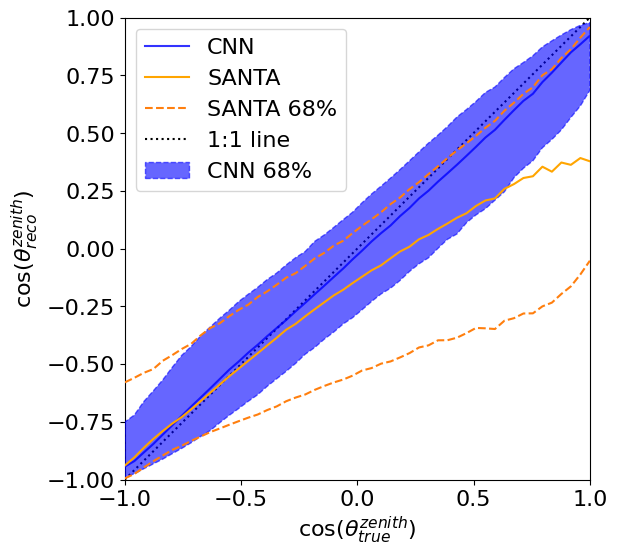

In [53]:

bins=np.linspace(-1,1,100)
plot_reco_vs_true(
    df_flercnn,
    df_santa[mask],
    leg1="CNN",
    leg2='SANTA',
    bins=bins,
    true_key='MCInIcePrimary.dir.coszen',
    reco_key1='FLERCNN_coszen',
    reco_key2='SANTA_LEERAFit_DefaultSelection_Particle.dir.coszen',
    unit=None,
    rad2deg=False,
    output_dir='plots',
    include_events_hist=False,
)

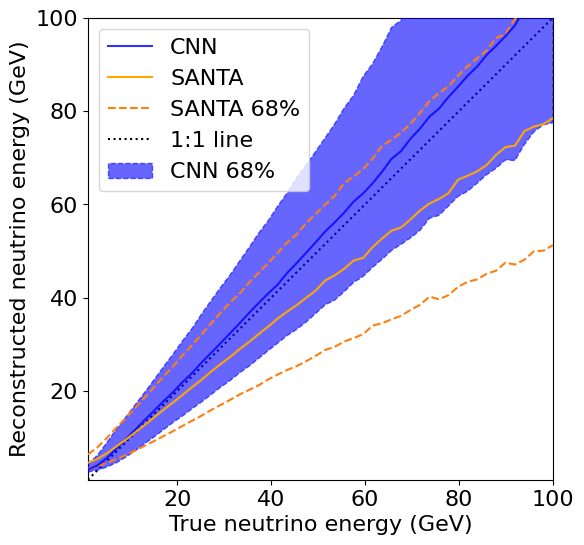

In [54]:

bins=np.logspace(0,2,100)
plot_reco_vs_true(
    df_flercnn,
    df_santa[mask],
    leg1="CNN",
    leg2='SANTA',
    bins=bins,
    true_key='MCInIcePrimary.energy',
    reco_key1='FLERCNN_energy',
    reco_key2='SANTA_LEERAFit_DefaultSelection_Particle.energy',
    unit="GeV",
    rad2deg=False,
    output_dir='plots',
    include_events_hist=False,
)

In [55]:
f_gnn["dir.coszen"] = np.cos(f_gnn["zenith"])

In [56]:
gnn_numu_cc = np.logical_and(f_gnn["interaction_type"]==1,abs(f_gnn["pid"]) == 14)
gnn_nue_cc = np.logical_and(f_gnn["interaction_type"]==1,abs(f_gnn["pid"]) == 12)

In [41]:
recos = ["flercnn","retro","gnn"]
#keys = ["run_id","event_id","sub_event_id"]
keys = ["energy"]
data = {}
particle = "numu_cc"
pid = 14
data[particle] = {}
branch =  "MCInIcePrimary." #"I3EventHeader."
mask = {}
for r in recos:
    data[particle][r] = {}

for k in keys:
    data[recos[0]][k] = MC_flercnn[branch+k] 
    #data[particle][recos[1]][k] = f_retro[particle][branch+k]
    data[recos[1]][k] = MC_gnn[branch+k]
    
    data[particle][recos[0]][k] = f_flercnn[particle][branch+k]
    data[particle][recos[1]][k] = f_retro[particle][branch+k]

    data[particle][recos[2]][k] = f_gnn[k][gnn_nue_cc] #f_val[particle][branch+k]


for r in recos:
    data[r] = {}

for k in keys:
    data[recos[0]][k] = MC_flercnn[branch+k] 
    #data[particle][recos[1]][k] = f_retro[particle][branch+k]
    data[recos[1]][k] = df_santa[branch+k]
    
for r in recos:
    stacked_arr = np.vstack((data[particle][r][keys[0]],data[particle][r][keys[1]]))
                             #,data[particle][r][keys[2]]))
    #string_arr = np.char.mod('%d',stacked_arr)
    #data[particle][r]["unique_id"] = np.char.add(string_arr[0,:], np.char.add(string_arr[1,:],string_arr[2,:]))
    #data[particle][r]["unique_id"] = np.char.add(string_arr[0,:],np.char.add(string_arr[1,:],string_arr[2,:]))
    data[particle][r]["unique_id"] = stacked_arr[0,:]*stacked_arr[1,:]
    # Check to make sure each event has a uniqueID
    #print(r,len(set(np.array(data[particle][r]["unique_id"]))),len(data[particle][r]["unique_id"]))
    assert(len(set(np.array(data[particle][r]["unique_id"])))==len(data[particle][r]["unique_id"]))

common_numbers3 = find_common_number3(data[particle][recos[0]]["unique_id"],
                                      data[particle][recos[1]]["unique_id"],
                                     data[particle][recos[2]]["unique_id"])
assert(len(common_numbers3)<len(data[particle][recos[2]]["unique_id"])) #should not exceed valdiation sample size

for r in recos:
    mask[r] = (create_mask(data[particle][r]["unique_id"],common_numbers3))

In [55]:
flercnn_masked = f_flercnn[particle][mask['flercnn']]
retro_masked = f_retro[particle][mask['retro']]
gnn_masked = f_gnn[particle][mask['gnn']]


TypeError: Accessing a group is done with bytes or str, not <class 'numpy.ndarray'>

In [42]:
fler = data[particle][recos[0]]["unique_id"]
ret = data[particle][recos[1]]["unique_id"]
gnn = data[particle][recos[2]]["unique_id"]
#common_numbers3 = find_common_number3(fler,ret,val)
print(len(common_numbers3),len(gnn))
#common_numbers2 = find_common_number2(fler,ret)
#print(len(common_numbers2))

271318 558136


In [43]:
fler_indices = np.where(np.isin(fler,common_numbers3))[0]
fler_mask = create_mask(fler,common_numbers3)

In [106]:
keys = ["ReferenceWeight",
        "FLERCNN_vertex_x", "FLERCNN_vertex_y", "FLERCNN_vertex_z", "FLERCNN_BDT_ProbNu",
        "FLERCNN_vertex_rho36", "FLERCNN_coszen", 
        "FLERCNN_energy", 'FLERCNN_nDOM', 'FLERCNN_prob_muon_v3', 'FLERCNN_prob_nu', 'FLERCNN_prob_track',
        'L4_MuonClassifier_Data_ProbNu',
        'L7_CoincidentMuon_Variables.z_travel_top15', 'L7_CoincidentMuon_bool', 'L7_NarrowCorridorCutPulsesHitStatistics.z_min',
        'L7_CoincidentMuon_Variables.n_outer', 'L7_CoincidentMuon_Variables.n_top15', 'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms',
        'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'
       ]
f_muon = "hdf5/oscNext_pisa_muongun_130000_flercnn.hdf5"
MC_muon = load_file(f_muon, keys, ['muon'])

In [107]:
muon_cuts = (MC_muon['FLERCNN_vertex_z'] > -495.) & (MC_muon['FLERCNN_vertex_z'] < -225.) & (MC_muon['FLERCNN_vertex_rho36'] < 200.) \
    & ( MC_muon['L7_CoincidentMuon_Variables.n_top15'] < 0.5 ) & ( MC_muon['L7_CoincidentMuon_Variables.n_outer'] < 7.5 ) \
    & (MC_muon['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms'] > 2.5) & (MC_muon['FLERCNN_nDOM'] >=7) \
    & (MC_muon['FLERCNN_energy'] >= 5.) & (MC_muon['FLERCNN_energy'] <= 100.) & (MC_muon['FLERCNN_coszen'] <= 0.0)
MC_muon = MC_muon[muon_cuts]

In [108]:
f_name = "hdf5/oscNext_pisa_genie_0000_flercnn.hdf5"
keys = ['I3MCWeightDict.OneWeight', 'I3MCWeightDict.InteractionType', 'MCInIcePrimary.pdg_encoding',
        'I3EventHeader.event_id', 'I3EventHeader.run_id',  'I3EventHeader.sub_run_id', 
        'MCInIcePrimary.dir.coszen', 'MCInIcePrimary.energy', 'MCInIcePrimary.pos.z', 'MCExtraTruthInfo.vertex_rho36',
        'MCInIcePrimary.pos.x', 'MCInIcePrimary.pos.y', 'MCExtraTruthInfo.vertex_rho36',
    
        "FLERCNN_vertex_x", "FLERCNN_vertex_y", "FLERCNN_vertex_z", "FLERCNN_BDT_ProbNu",
        "FLERCNN_vertex_rho36", "FLERCNN_coszen", 
        "FLERCNN_energy", 'FLERCNN_nDOM', 'FLERCNN_prob_muon_v3', 'FLERCNN_prob_nu', 'FLERCNN_prob_track',
        'L4_MuonClassifier_Data_ProbNu',
        'L7_CoincidentMuon_Variables.z_travel_top15', 'L7_CoincidentMuon_bool', 'L7_NarrowCorridorCutPulsesHitStatistics.z_min',
        'L7_CoincidentMuon_Variables.n_outer', 'L7_CoincidentMuon_Variables.n_top15', 'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms',
        'L5_SANTA_DirectPulsesHitMultiplicity.n_hit_strings'
       ]

MC = load_file(f_name, keys,['all'])
MC['I3MCWeightDict.OneWeight'] = correct_weights(MC['I3MCWeightDict.OneWeight'], np.abs(MC['MCInIcePrimary.pdg_encoding']))
print(f'Loaded {MC.size} events')

Loaded 8632740 events


In [109]:
cuts = (MC.FLERCNN_vertex_z > -495.) & (MC.FLERCNN_vertex_z < -225.) & (MC.FLERCNN_vertex_rho36 < 200.) \
    & ( MC['L7_CoincidentMuon_Variables.n_top15'] < 0.5 ) & ( MC['L7_CoincidentMuon_Variables.n_outer'] < 7.5 ) \
    & (MC['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms'] > 2.5) & (MC.FLERCNN_nDOM >=7) \
    & (MC['FLERCNN_energy'] >= 5.) & (MC['FLERCNN_energy'] <= 100.) & (MC['FLERCNN_coszen'] <= 0.0)
MC = MC[cuts]

In [110]:
def get_roc(MC, weights=None, e_lim=500):
    trck = ((MC['MCInIcePrimary.pdg_encoding'] == 14 | (MC['MCInIcePrimary.pdg_encoding'] == -14)) & (MC['I3MCWeightDict.InteractionType'] == 1))

    false_pos, true_pos = [1], [1]
    for d in np.quantile(MC['FLERCNN_prob_track'], np.linspace(0,1,50)):
        false_pos.append(np.sum(weights[(~trck)&(MC['FLERCNN_prob_track']> d)&(MC['MCInIcePrimary.energy'] < e_lim)]) / np.sum(weights[(~trck)&(MC['MCInIcePrimary.energy'] < e_lim)]))
        true_pos.append(np.sum(weights[(trck)&(MC['FLERCNN_prob_track'] > d)&(MC['MCInIcePrimary.energy'] < e_lim)]) / np.sum(weights[(trck)&(MC['MCInIcePrimary.energy'] < e_lim)]))
    
    auc = -np.trapz(true_pos, x=false_pos)
    
    return false_pos, true_pos, auc

In [111]:
false_pos, true_pos, auc = get_roc(MC, weights=MC['I3MCWeightDict.OneWeight'], e_lim=500)

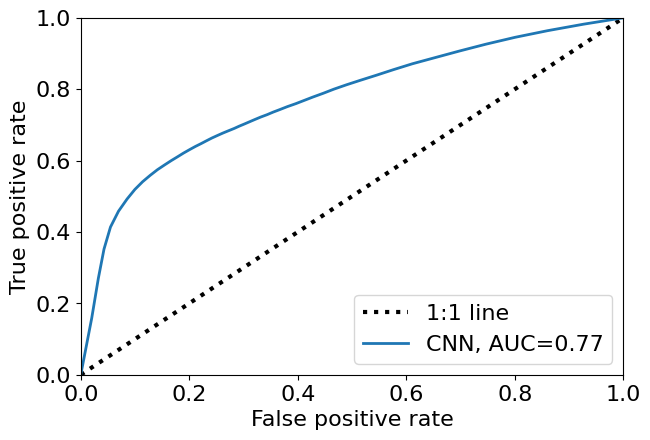

In [112]:
colors = ['tab:blue', 'tab:orange']
style = ['-', '--']
plt.figure(figsize=(7, 7.5*0.618))

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), color='black', linestyle=':', linewidth=3, label='1:1 line')
plt.plot(false_pos, true_pos, label='CNN, AUC=%.2f'%(auc),
         linewidth=2, linestyle=style[0], color=colors[0])

plt.legend(prop={'size': 16})#, bbox_to_anchor=(1, 1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('plots/pid_roc.pdf', bbox_inches='tight')

In [113]:
def plot_PID(key, MC=MC, bins=60, true_label="Track", false_label='Cascade'):

    trck = ((MC['MCInIcePrimary.pdg_encoding'] == 14 | (MC['MCInIcePrimary.pdg_encoding'] == -14)) & (MC['I3MCWeightDict.InteractionType'] == 1))
    plt.hist(MC[key][trck], bins, label=true_label, color="tab:blue", weights=MC['I3MCWeightDict.OneWeight'][trck],density=True, alpha=0.6)
    plt.hist(MC[key][~trck], bins, label=false_label, color="tab:red", weights=MC['I3MCWeightDict.OneWeight'][~trck],density=True, alpha=0.6)
    #plt.axvline(med, label='Median: %.2f'%(med), color='r')
    #plt.axvline(mean, label='Mean: %.2f'%(mean), color='orange')
    plt.legend(loc="upper left")
    plt.xlim(0,1)
    plt.xlabel('PID')
    plt.ylabel('Density')
    #plt.yscale('log')
    plt.savefig('plots/PID.pdf', bbox_inches='tight')

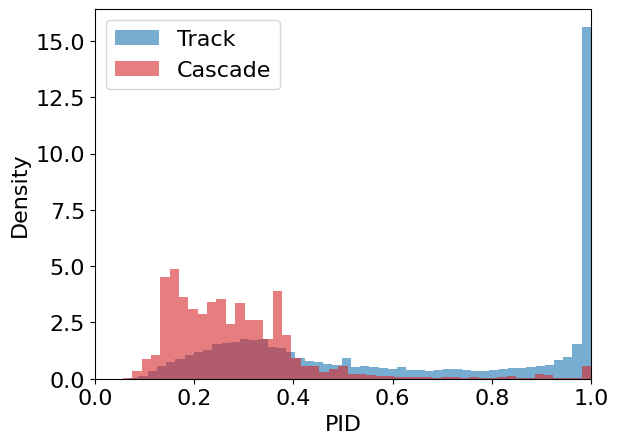

In [114]:
plot_PID('FLERCNN_prob_track', bins=50, true_label="Track", false_label='Cascade')

In [115]:
def plot_muonID(key='FLERCNN_prob_nu', MC=MC, MC_muon=MC_muon,bins=60, true_label="Neutrino", false_label='Muon'):
    plt.hist(MC[key], bins, label=true_label, color="tab:blue", weights=MC['I3MCWeightDict.OneWeight'],density=True, alpha=0.6)
    plt.hist(MC_muon[key], bins, label=false_label, color="tab:red", weights=MC_muon['ReferenceWeight'],density=True, alpha=0.6)
    #plt.axvline(med, label='Median: %.2f'%(med), color='r')
    #plt.axvline(mean, label='Mean: %.2f'%(mean), color='orange')
    plt.legend(loc="upper left")
    plt.xlim(0,1)
    plt.xlabel('Neutrino Classifier')
    plt.ylabel('Density')
    #plt.yscale('log')
    plt.savefig('plots/muonID.pdf', bbox_inches='tight')

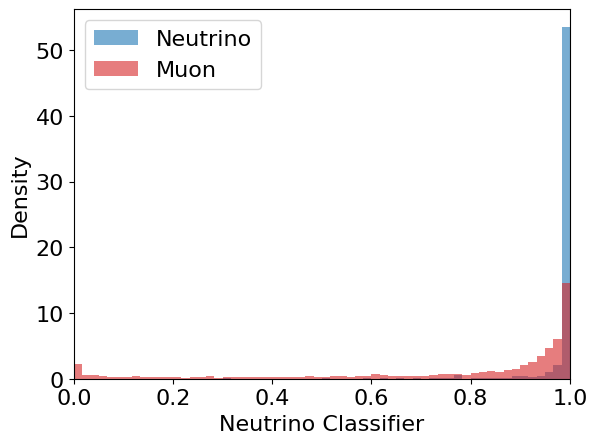

In [116]:
plot_muonID('FLERCNN_prob_nu')

In [117]:
def get_muon_roc(MC, MC_muon, e_lim=100):
    muon_weights=MC_muon['ReferenceWeight']
    weights=MC['I3MCWeightDict.OneWeight']
    false_pos, true_pos = [1], [1]
    for d in np.quantile(MC_muon['FLERCNN_prob_nu'], np.linspace(0,1,100)):
        false_pos.append(np.sum(muon_weights[MC_muon['FLERCNN_prob_nu']> d]) / np.sum(muon_weights))
        true_pos.append(np.sum(weights[(MC['FLERCNN_prob_nu'] > d)&(MC['MCInIcePrimary.energy'] < e_lim)]) / np.sum(weights[(MC['MCInIcePrimary.energy'] < e_lim)]))
    
    auc = -np.trapz(true_pos, x=false_pos)
    
    return false_pos, true_pos, auc

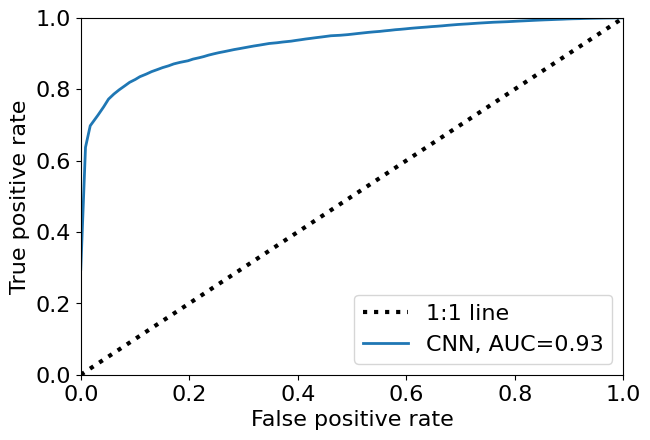

In [118]:
false_pos, true_pos, auc = get_muon_roc(MC, MC_muon)
colors = ['tab:blue', 'tab:orange']
style = ['-', '--']
plt.figure(figsize=(7, 7.5*0.618))

plt.plot(np.linspace(0, 1, 2), np.linspace(0, 1, 2), color='black', linestyle=':', linewidth=3, label='1:1 line')
plt.plot(false_pos, true_pos, label='CNN, AUC=%.2f'%(auc),
         linewidth=2, linestyle=style[0], color=colors[0])

plt.legend(prop={'size': 16})#, bbox_to_anchor=(1, 1))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xlim(0,1)
plt.ylim(0,1)
plt.savefig('plots/pid_roc.pdf', bbox_inches='tight')

### # pulses, channels, strings, ...

In [319]:
def plot_hist(key, bins=100, label=None):
    if label == None: label = key
    med, mean = np.median(MC[key]), np.mean(MC[key])
    plt.hist(MC[key], bins)
    plt.axvline(med, label='Median: %.2f'%(med), color='r')
    plt.axvline(mean, label='Mean: %.2f'%(mean), color='orange')
    plt.legend()
    plt.xlabel(label)
    plt.ylabel('#events')
    plt.yscale('log')

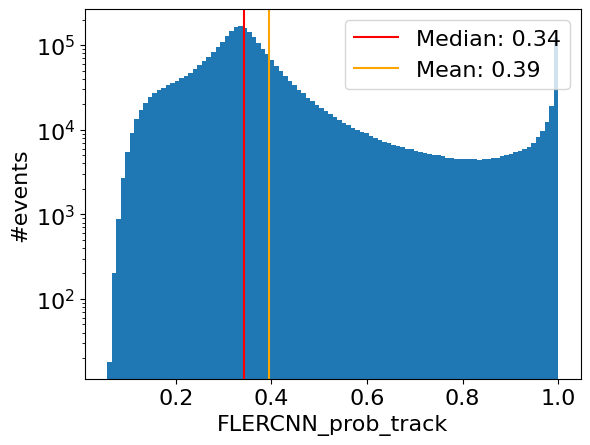

In [320]:
plot_hist('FLERCNN_prob_track')
#plt.savefig('plots/not_in_paper/L7_nchannel_used_in_retro', bbox_inches='tight')

In [ ]:
plt.suptitle('SRTTWOfflinePulsesDCHitMultiplicity', y=0.93, size=20)
plt.subplots_adjust(wspace=0.2, hspace=0.25)

plt.subplot(221)
plot_hist('SRTTWOfflinePulsesDCHitMultiplicity.n_pulses', label='n_pulses')

plt.subplot(222)
plot_hist('SRTTWOfflinePulsesDCHitMultiplicity.n_hit_doms', label='n_hit_doms')

plt.subplot(223)
plot_hist('SRTTWOfflinePulsesDCHitMultiplicity.n_hit_doms_one_pulse', 80, label='n_hit_doms_one_pulse')

plt.subplot(224)
plot_hist('SRTTWOfflinePulsesDCHitMultiplicity.n_hit_strings', 30, label='n_hit_strings')

#plt.savefig('plots/not_in_paper/SRTTWOfflinePulsesDCHitMultiplicity', bbox_inches='tight')

In [ ]:
plt.hist(MC['SRTTWOfflinePulsesDCHitMultiplicity.n_hit_doms']-MC.L7_nchannel_used_in_retro, 27)
plt.yscale('log')

### retro fit success

In [ ]:
nums = []
for i in range(4):
    nums.append(np.sum(MC.retro_crs_prefit__stopping_flag==i))
labels = ['max call exceeded', 'std(llh) < threshold', 'no improvment \n after n iterations', 'std(x) < threshold']

In [ ]:
patches, texts, autotexts = plt.pie(nums, labels=labels, autopct='%1.1f%%')
for i in range(4):
    autotexts[i].set_fontsize(16)
#plt.title('retro_crs_prefit__stopping_flag')
#plt.savefig('plots/not_in_paper/retro_crs_prefit__stopping_flag', bbox_inches='tight')

### LLH calls

In [ ]:
plot_hist('retro_crs_prefit__iterations')
#plt.savefig('plots/not_in_paper/retro_n_iters')

In [ ]:
np.quantile(MC.retro_crs_prefit__iterations, 0.99)

### Number of channels

In [ ]:
N_N = (MC['L5_SANTA_DirectPulsesHitMultiplicity.n_hit_doms']/MC['SRTTWOfflinePulsesDCHitMultiplicity.n_hit_doms'])[mask]

med, mean = np.median(N_N), np.mean(N_N)
plt.hist(N_N, 100)
plt.axvline(med, label='Median: %.2f'%(med), color='r')
plt.axvline(mean, label='Mean: %.2f'%(mean), color='orange')
plt.legend()
plt.xlabel(r'$N_{ch,SANTA}/N_{ch,Retro}$')
plt.ylabel('#events')
#plt.yscale('log')
#plt.savefig('plots/not_in_paper/Nch_SANTA_Nch_retro')